# Video Classification with Transformers

Classificando videos do Dataset ChaLearn em extrovertido (1) ou não (0).

Os video do Dataset já foram processados em passo anterior seguindo os seguites passos:

> Video -> EfficientNet B0 como extratora de características -> Redução de Dimensionalidade com PCA

Este notebook tem por objetivo construir uma arquitetura baseada em Transformers que busca realizar a classificação.

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [14]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
# import imageio
import cv2
import os

In [15]:
# Hiperparâmetros

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 30

## Import the data

In [16]:
train_data = np.load('../train_data_with_pca.npy')
train_labels = np.load('../train_labels.npy')

print(f"train_data shape: {train_data.shape}")
print(f"train_labels shape: {train_labels.shape}")

train_data shape: (3118, 20, 1024)
train_labels shape: (3118,)


## Building the Transformer-based model

In [18]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [19]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [22]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4 # try 16 or 32
    num_heads = 1 # try 4

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, kernel_initializer='normal', activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
#     _, accuracy = model.evaluate(test_data, test_labels)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model

In [23]:
trained_model = run_experiment()

2022-06-14 22:22:44.671515: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-06-14 22:22:44.671595: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cruzeiro
2022-06-14 22:22:44.671616: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cruzeiro
2022-06-14 22:22:44.671746: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-14 22:22:44.671799: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-14 22:22:44.671816: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.103.1 does not match DSO version 470.129.6 -- cannot find working devices in this configuration
2022-06-14 22:22:44.672329: I tensorflow/core/platform/cpu_feature_guard.cc:151] This Tensor

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.8866 - accuracy: 0.6800
Epoch 1: val_loss improved from inf to 1.33764, saving model to /tmp/video_classifier
83/83 [==============================] - 9s 89ms/step - loss: 0.8866 - accuracy: 0.6800 - val_loss: 1.3376 - val_accuracy: 0.6154
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.4323 - accuracy: 0.8415
Epoch 2: val_loss improved from 1.33764 to 1.28343, saving model to /tmp/video_classifier
83/83 [==============================] - 7s 84ms/step - loss: 0.4323 - accuracy: 0.8415 - val_loss: 1.2834 - val_accuracy: 0.6346
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.8932
Epoch 3: val_loss did not improve from 1.28343
83/83 [==============================] - 7s 79ms/step - loss: 0.2811 - accuracy: 0.8932 - val_loss: 1.4697 - val_accuracy: 0.7286
Epoch 4/30
83/83 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.9109
Epoch 4: va

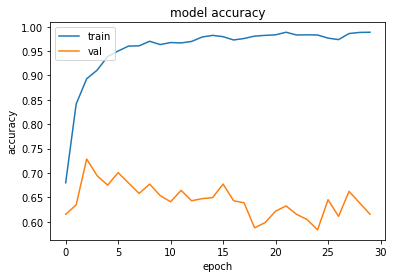

In [33]:
train_accuracy = trained_model.history.history["accuracy"]
val_accuracy = trained_model.history.history["val_accuracy"]

# summarize history for accuracy
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()